## Preparation

In [1]:
# Libraries 
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tf_utils
from time import time
from datetime import date
import json
import pathlib

In [9]:
# Parameters
EPOCHS = 50
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
SEED = 123

FPATH = 'C:/Users/User/Desktop/saved_models'

In [3]:
# Dataset preparation
train_part, valid_part, test_part = 0.7, 0.15, 0.15

# Loading
ds_kaggle = tf.keras.utils.image_dataset_from_directory(
    'kaggle dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

nature_ds = tf.keras.utils.image_dataset_from_directory(
    'nature dataset',
    validation_split=0,
    shuffle=True,
    seed=SEED,
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE
)

class_names = ds_kaggle.class_names
no_classes = len(class_names)

# Splitting
train_ds, valid_ds, test_ds = tf_utils.get_dataset_partitions(ds_kaggle, train_part, valid_part, test_part, seed=SEED)
print(f'Batches ({BATCH_SIZE} images per batch) in subsets:')
print(f'Train: {len(train_ds)}')
print(f'Validation: {len(valid_ds)}')
print(f'Test: {len(test_ds)}')

# Normalization
train_ds = train_ds.map(tf_utils.normalize)
valid_ds = valid_ds.map(tf_utils.normalize)
test_ds = test_ds.map(tf_utils.normalize)
nature_ds = nature_ds.map(tf_utils.normalize)

Found 10033 files belonging to 75 classes.
Found 138 files belonging to 75 classes.
Batches (32 images per batch) in subsets:
Train: 219
Validation: 47
Test: 48


## Fitting

In [10]:
# Constructing a model
name = 'VGG16'
# Loading pretrained convolutional layers of the model
pretrained = tf.keras.applications.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(*IMG_SIZE, 3),
    pooling='max'
)

# Disabling training of pretrained layers
for layer in pretrained.layers:
    layer.trainable = False

# Creating the model - adding fully connected layers on top of model
model = tf.keras.models.Sequential(name=name)
model.add(pretrained)
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5, seed=SEED))
model.add(tf.keras.layers.Dense(4096, activation='relu'))
model.add(tf.keras.layers.Dropout(rate=0.5, seed=2*SEED))
model.add(tf.keras.layers.Dense(no_classes, activation='softmax'))

# Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [6]:
model.summary()

Model: "VGG16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_1 (Dense)             (None, 4096)              2101248   
                                                                 
 dropout (Dropout)           (None, 4096)              0         
                                                                 
 dense_2 (Dense)             (None, 4096)              16781312  
                                                                 
 dropout_1 (Dropout)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 75)                307275    
                                                                 
Total params: 33,904,523
Trainable params: 19,189,835
Non-tra

In [11]:
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

training_date = date.today()
model_dir_name = f'{model.name}_({training_date})_'
ctr = [p.name[:-1] for p in pathlib.Path(FPATH).glob('*')].count(model_dir_name)
model_dir_name += str(ctr)

callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        f'{FPATH}/{model_dir_name}/model',
        monitor='val_acc',
        save_best_only=True
    )
]

t0 = time()

history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_ds,
    steps_per_epoch=len(train_ds),
    validation_steps=len(valid_ds),
    callbacks=callbacks
)

training_time = time() - t0

Epoch 1/50
219/219 [==============================] - 1114s 5s/step - loss: 3.6710 - accuracy: 0.1290 - val_loss: 2.1731 - val_accuracy: 0.4419
Epoch 2/50
219/219 [==============================] - 1107s 5s/step - loss: 2.3337 - accuracy: 0.3627 - val_loss: 1.5971 - val_accuracy: 0.5353
Epoch 3/50
219/219 [==============================] - 1099s 5s/step - loss: 2.0317 - accuracy: 0.4298 - val_loss: 1.3390 - val_accuracy: 0.6414
Epoch 4/50
219/219 [==============================] - 1088s 5s/step - loss: 1.8292 - accuracy: 0.4739 - val_loss: 1.1102 - val_accuracy: 0.7018
Epoch 5/50
219/219 [==============================] - 1100s 5s/step - loss: 1.7901 - accuracy: 0.4750 - val_loss: 1.1591 - val_accuracy: 0.6817
Epoch 6/50
219/219 [==============================] - 1115s 5s/step - loss: 1.6493 - accuracy: 0.5116 - val_loss: 0.9846 - val_accuracy: 0.7361
Epoch 7/50
219/219 [==============================] - 1120s 5s/step - loss: 1.6145 - accuracy: 0.5263 - val_loss: 0.9609 - val_accuracy:

INFO:tensorflow:Assets written to: C:/Users/User/Desktop/saved_models/VGG16_(2023-03-15)/model\assets


INFO:tensorflow:Assets written to: C:/Users/User/Desktop/saved_models/VGG16_(2023-03-15)/model\assets


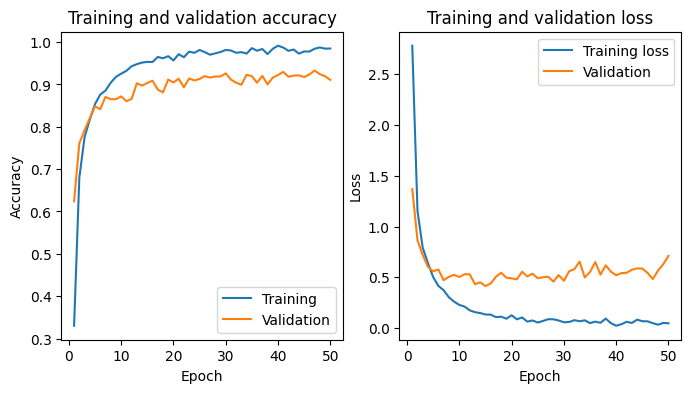

In [ ]:
model.save(f'{FPATH}/{model_dir_name}/model')
 
tf_utils.plot_history(history)

json.dump(history.history, open(f'{FPATH}/{model_dir_name}/history.json', 'w'))

In [7]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

48/48 [==============================] - 218s 4s/step - loss: 0.6300 - accuracy: 0.9023
Kaggle set evaluation: 
Test loss: 0.6299895644187927
Test accuracy: 0.90234375


1/1 [==============================] - 4s 4s/step


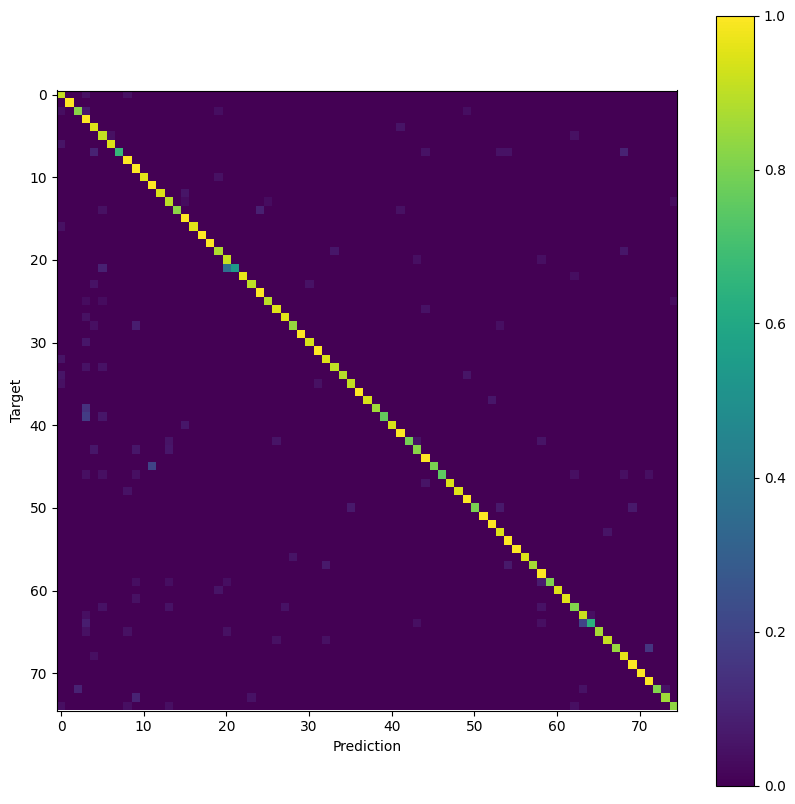

In [8]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m)
plt.show()

In [9]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

5/5 [==============================] - 25s 5s/step - loss: 2.6890 - accuracy: 0.7246
Nature set evaluation: 
Test loss: 2.6889724731445312
Test accuracy: 0.7246376872062683


1/1 [==============================] - 1s 1s/step


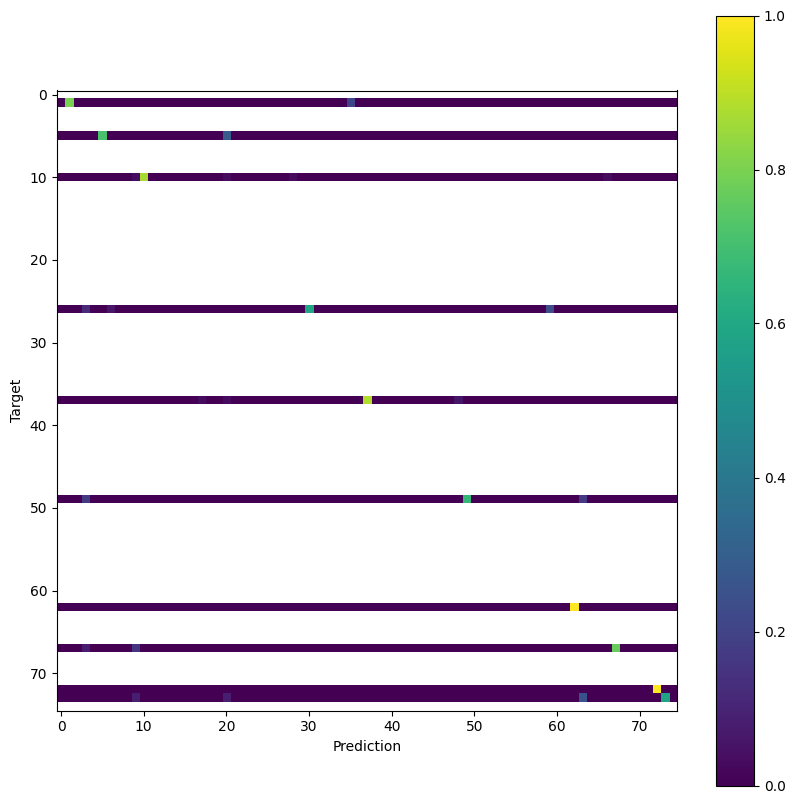

In [12]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m)
plt.show()

In [15]:
info = {
    'date': training_date.isoformat(),
    'duration': training_time,
    'name': model.name,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'test_confusion': m.tolist(),
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'nature_confusion': nature_m.tolist(),
    'comments': "Pretrained VGG16 model with top FC layers (2048,1024,75). Probably it is better to use smaller FC layers."
    }

json.dump(info, open(f'{FPATH}/{model_dir_name}/info.json', 'w'))

## Loaded

In [7]:
# Lookup model 
[print(i) for i in pathlib.Path(FPATH).glob('*')]

C:\Users\User\Desktop\saved_models\model1
C:\Users\User\Desktop\saved_models\model2
C:\Users\User\Desktop\saved_models\vgg1_pret


[None, None, None]

In [10]:
# Load model and data
model_dir = 'vgg1_pret'

model = tf.keras.models.load_model(f'{FPATH}/{model_dir}')

In [9]:
test_loss, test_accuracy = model.evaluate(test_ds)
print('Kaggle set evaluation: ')
print(f'Test loss: {test_loss}')
print(f'Test accuracy: {test_accuracy}')

25/25 [==============================] - 182s 7s/step - loss: 0.0207 - accuracy: 0.9950
Kaggle set evaluation: 
Test loss: 0.020665638148784637
Test accuracy: 0.9950000047683716


2/2 [==============================] - 7s 4s/step


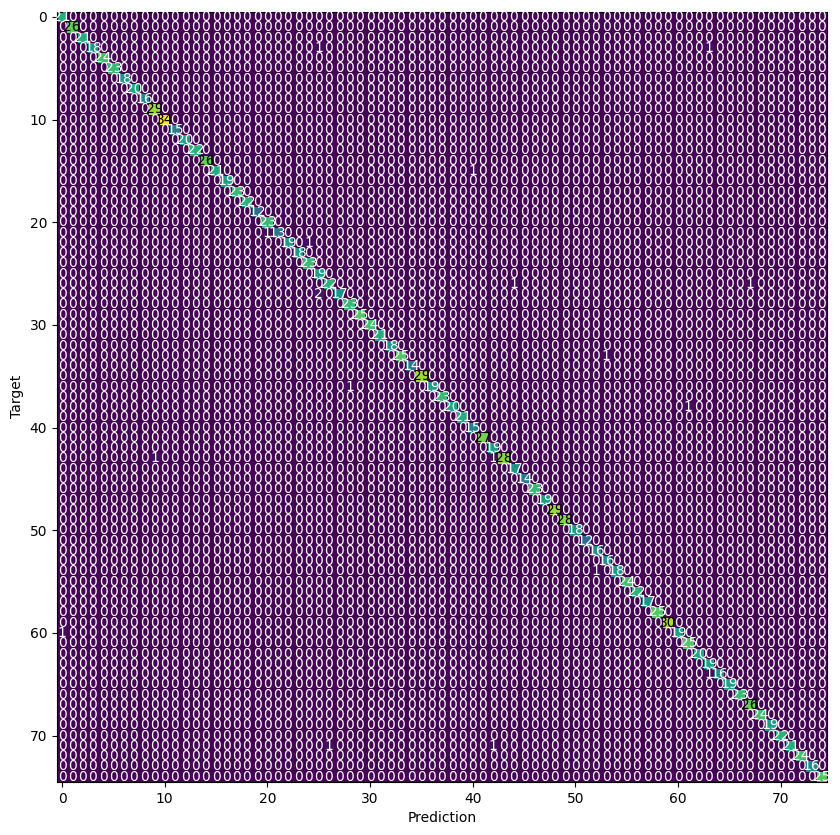

In [10]:
targets = []
predictions = []
for test_images, test_labels in test_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(m)
plt.show()

In [11]:
nature_test_loss, nature_test_accuracy = model.evaluate(nature_ds)
print('Nature set evaluation: ')
print(f'Test loss: {nature_test_loss}')
print(f'Test accuracy: {nature_test_accuracy}')

3/3 [==============================] - 17s 4s/step - loss: 2.8614 - accuracy: 0.7174
Nature set evaluation: 
Test loss: 2.861356735229492
Test accuracy: 0.717391312122345


1/1 [==============================] - 1s 1s/step


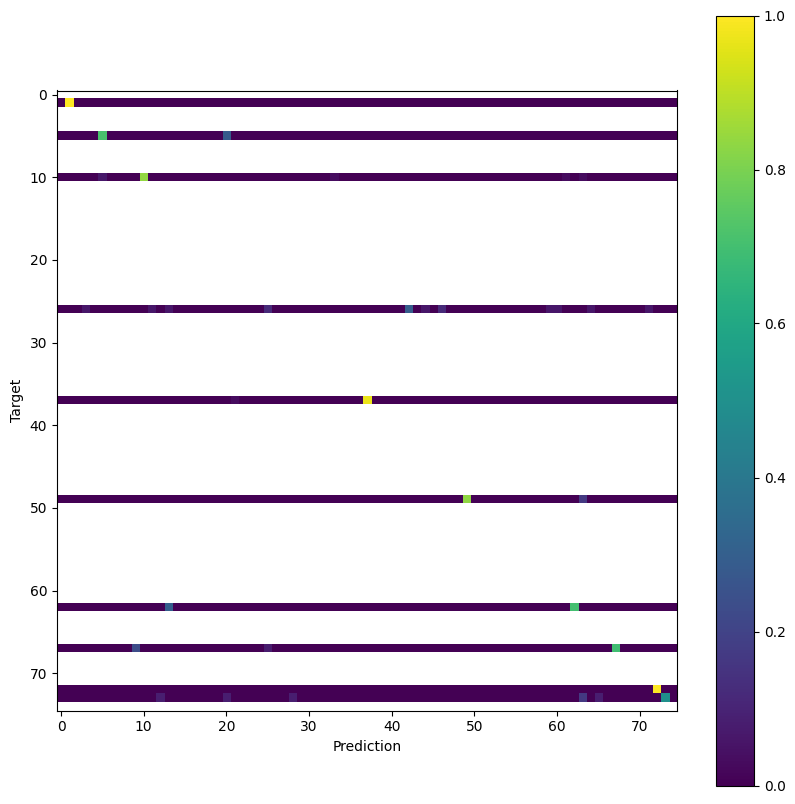

In [13]:
targets = []
predictions = []
for test_images, test_labels in nature_ds.take(-1):
    targets.append(test_labels)
    predictions.append(model.predict(test_images))

nature_m = tf_utils.confusion_matrix(predictions, targets, no_classes)
tf_utils.plot_confusion_matrix(nature_m)
plt.show()

In [ ]:
info = {
    'date': training_date,
    'duration': training_time,
    'name': model.name,
    'test_accuracy': test_accuracy,
    'test_loss': test_loss,
    'test_confusion': m,
    'nature_accuracy': nature_test_accuracy,
    'nature_loss': nature_test_loss,
    'nature_confusion': nature_m
    }

json.dump(info, open(f'{FPATH}/{model.name}_({training_date})/info.json', 'w'))